# Plot bigger data

In [1]:
import sys;sys.path.append('../..')
from abslithist import *
FN_BIGGERDATA='../../data/scores/data.scores.biggerdata.v2.pkl'

In [2]:
datadir0=os.path.join(PATH_DATA,'scores','v4')
datadir=os.path.join(PATH_DATA,'scores','v5')

def get_fns():
    fns=[]
    fns+=[os.path.join(datadir0,fn,'cache') for fn in os.listdir(datadir0)]
    fns+=[os.path.join(datadir,fn,'cache') for fn in os.listdir(datadir)]
    return fns

In [3]:
get_fns()

['/home/ryan/github/abslithist/data/scores/v4/CanonFiction/cache',
 '/home/ryan/github/abslithist/data/scores/v4/ECCO_TCP/cache',
 '/home/ryan/github/abslithist/data/scores/v4/COHA/cache',
 '/home/ryan/github/abslithist/data/scores/v4/HathiEssays/cache',
 '/home/ryan/github/abslithist/data/scores/v4/EEBO_TCP/cache',
 '/home/ryan/github/abslithist/data/scores/v4/HathiEngLit/cache',
 '/home/ryan/github/abslithist/data/scores/v5/HathiStories/cache',
 '/home/ryan/github/abslithist/data/scores/v5/DialNarr/cache',
 '/home/ryan/github/abslithist/data/scores/v5/HathiSermons/cache',
 '/home/ryan/github/abslithist/data/scores/v5/EnglishDialogues/cache',
 '/home/ryan/github/abslithist/data/scores/v5/ChadwyckPoetry/cache',
 '/home/ryan/github/abslithist/data/scores/v5/ChadwyckDrama/cache',
 '/home/ryan/github/abslithist/data/scores/v5/HathiProclamations/cache',
 '/home/ryan/github/abslithist/data/scores/v5/GaleAmericanFiction/cache',
 '/home/ryan/github/abslithist/data/scores/v5/CanonFiction/cache

In [4]:
badcorps={'COCA','FanFic',
#           'ChadwyckPoetry',
          'PMLA'}

In [5]:
def titlegenre(title):
    twords=set(tokenize(title))
    
    keywords=[('Romance', {'romance', 'romances'}),
 ('Adventure', {'adventure', 'adventures'}),
 ('Tale', {'tale', 'tales'}),
 ('Novel', {'novel', 'novella', 'novels'}),
 ('Essay', {'essay', 'essays'}),
 ('History', {'histories', 'history'}),
 ('Sermon', {'sermon', 'sermons'}),
 ('Letters', {'letter', 'letters'}),
 ('Treatise', {'treatise', 'treatises'}),
 ('Discourse', {'discourse', 'discourses'}),
#  ('Fiction', {'rogue'})
]
    for g,gw in keywords:
        if twords&gw:
            return g
    return None

In [6]:
def getgenre(row):
    if row.genre and row.genre not in {'Prose','Essay','Treatise','Print','Unknown',''}:
        return row.genre
    return titlegenre(row.title)

In [7]:
import mpi_slingshot as sl

def load_df(cols=['id','title','year','genre','genre2','medium','corpus'],force=False):
    if os.path.exists(FN_BIGGERDATA) and not force: return lltk.read_df(FN_BIGGERDATA)
    
    fns=get_fns()
    dfs=[]
    iterr=tqdm(fns)
    for fn in iterr:
        cname=fn.split('/')[-2]
        if cname in badcorps: continue
        iterr.set_description(cname)
        try:
            df=pd.DataFrame([
                {
                    'id':idxd['id'],
                    'contrast':k.split('.')[0],
                    'source':k.split('.')[1],
                    'period':k.split('.')[2],
                    'value':v
                }
                for idxd,dx in sl.stream_results(fn,progress=False)
                for k,v in (dx if type(dx)==dict else {}).items()
                if type(idxd)==dict and 'id' in idxd
            ])
            dfmeta=lltk.load(cname).meta.reset_index()
        except Exception as e:
            print('!',e)
            continue
        dfmeta['corpus']=cname
        for c in cols: 
            if not c in dfmeta.columns:
                dfmeta[c]=''
        dfmeta['genre2']=dfmeta.apply(getgenre,axis=1)
        dfmeta['year']=pd.to_numeric(dfmeta['year'],errors='coerce')
        
        
#         display(dfmeta)
        try:
            dfm=dfmeta[cols].merge(df,on='id').groupby(cols+['period']).mean().reset_index()
        except Exception:
            continue
#         display(dfm)
        dfs.append(dfm)
#         break
    DF=pd.concat(dfs)
    lltk.save_df(DF,FN_BIGGERDATA)
    print('>> saved:',FN_BIGGERDATA)
    return DF

In [8]:
# df=load_df()
# df

In [9]:
# # !pip install pandarallel
# from pandarallel import pandarallel
# pandarallel.initialize(nb_workers=4,progress_bar=True)

In [10]:
# lltk.save_df(df,FN_BIGGERDATA)

In [11]:
df=load_df(force=False)
# df=lltk.read_df(FN_BIGGERDATA)
# df['genre2']=df.progress_apply(getgenre,axis=1)
# df['year2']=pd.to_numeric(df['year'],errors='coerce')
# lltk.save_df(df,FN_BIGGERDATA)
df

id  \
0         Addison.Spectator   
1         Addison.Spectator   
2         Addison.Spectator   
3         Addison.Spectator   
4         Addison.Spectator   
...                     ...   
25013  yale/390/02089542022   
25014  yale/390/02089542022   
25015  yale/390/02089542022   
25016  yale/390/02089542022   
25017  yale/390/02089542022   

                                                   title    year      genre  \
0                                         Spectator (A.)  1711.0    Fiction   
1                                         Spectator (A.)  1711.0    Fiction   
2                                         Spectator (A.)  1711.0    Fiction   
3                                         Spectator (A.)  1711.0    Fiction   
4                                         Spectator (A.)  1711.0    Fiction   
...                                                  ...     ...        ...   
25013  A history of the family of Seton during eight ...  1896.0  Biography   
25014  A history of the family of Seton during eight ...  1896.0  Biography   
25015  A history of the family of Seton during eight ...  1896.0  Biography   
25016  A history of the family of Seton during eight ...  1896.0  Biography   
25017  A history of the family of Seton during eight ...  1896.0  Biography   

          genre2 medium        corpus  period     value  
0        Fiction         CanonFiction     C16 -0.267648  
1        Fiction         CanonFiction     C17 -0.354306  
2        Fiction         CanonFiction     C18 -0.415953  
3        Fiction         CanonFiction     C19 -0.413507  
4        Fiction         CanonFiction     C20 -0.448908  
...          ...    ...           ...     ...       ...  
25013  Biography             HathiBio     C18 -0.109215  
25014  Biography             HathiBio     C19 -0.185244  
25015  Biography             HathiBio     C20 -0.218534  
25016  Biography             HathiBio  median -0.116424  
25017  Biography             HathiBio    orig  0.221780  

[3303888 rows x 9 columns]

In [12]:
# stop
len(set(df.id))

471818

In [13]:
titlegenre('Sermon of Robinson Crusoe, a')

In [14]:
df['corpus'].value_counts()

ChadwyckPoetry        2045498
COHA                   816193
EEBO_TCP               168756
Chicago                 63623
ChadwyckDrama           39641
NewYorker               32851
InternetArchive         25368
HathiBio                25018
DialNarr                13426
CanonFiction            12656
Sellers                 12159
ECCO_TCP                 6818
HathiNovels              6447
Spectator                5894
HathiLetters             5866
OldBailey                4459
HathiTales               3640
HathiTreatises           3045
Chadwyck                 2926
HathiSermons             2751
MarkMark                 2485
CLMET                    1799
HathiStories             1085
HathiEssays               952
HathiProclamations        427
GildedAge                 105
Name: corpus, dtype: int64

In [15]:
df['genre2'].value_counts()

Verse                     2108358
Magazine                   429044
News                       291739
Fiction                    150304
Drama                       58296
Letters                     40439
Periodical                  38745
Sermon                      35840
Biography                   26012
Non-Fiction                 24339
Novel                       22008
Tale                        11620
Treatise                    11291
Discourse                   11151
History                      7875
Fictional Narration          6076
Fictional Dialogue           6076
Essay                        4634
Romance                      4620
Trial                        4459
Poetry                       2835
Adventure                    2569
Film                         2030
Story                        1085
Fictional Txtnarration        637
Fictional Txtdialogue         637
Proclamation                  427
Oratory                       378
Other                         217
Miscellany    

In [16]:
# df.query('year2<1600').query('metagenre=="Non-Fiction"')

In [17]:
def metagenre(g):
    if g in {'Essay','Treatise','Discourse'}: return 'Non-Fiction'#Essay/Treatise/Discourse'
    if g in {'Sermon'}: return g#,'Letters'}: return g
    if g in {'Fiction','Novel'}: return 'Fiction'
#     if g in {'Romance','Adventure','Tale','Fiction','Fictional Narration','Fictional Dialogue','Novel','Adventure'}:
    if g in {'Romance','Fiction','Novel'}:
        return 'Fiction'
    if g in {'Verse','Poetry'}: return 'Verse'
    if g in {'Drama'}: return None#'Drama'
    if g in {'Biography'}: return 'Biography'
    if g in {'Essay','Letters','Non-Fiction','Discourse','Treatise'}: return 'Non-Fiction'
    return None

In [18]:
df['metagenre']=df.genre2.progress_apply(metagenre)

100%|██████████| 3303888/3303888 [00:01<00:00, 1691135.05it/s]


In [19]:
df['year_period']=df['year'].apply(lambda x: str(year2period(x))[:3])
# df

In [20]:
composite = pd.DataFrame(df[df.period == df.year_period])
composite['period']='Dynamic'
# composite

In [21]:
# okgenres={'Letters','Sermon','Essay','Treatise','Discourse','Romance','Novel','Fiction'}
badmetagenres={'Sermon','Letters','Drama','Biography'}#,'Non-Fiction'}

In [22]:
y1,y2=1500,2020
figdf=df.append(composite)
figdf=figdf[~figdf.period.isin({'orig','median'})]
figdf=figdf[~figdf.metagenre.isnull()].query(f'{y1}<=year<={y2}')
figdf['dec']=figdf['year']//10*10
figdf['corpgenre']=[f'{g} ({c})' for g,c in zip(figdf.genre2,figdf.corpus)]
# figdf=figdf.groupby(['dec','genre2','metagenre','corpus','period']).mean().reset_index()
figdf=figdf.groupby(['year','genre2','metagenre','corpus','period']).mean().reset_index()
figdf=figdf[~figdf.metagenre.isin(badmetagenres)]
figdf=figdf[(figdf.corpus!='COHA') | (figdf.genre2!='Fiction')]
badcorps={'DialNarr','HathiTales','HathiNovels'}#,'CanonFiction'}
figdf=figdf[~figdf.corpus.isin(badcorps)]
figdf

year   genre2 metagenre        corpus   period     value     dec
0      1500.0  Fiction   Fiction  CanonFiction      C16 -0.034399  1500.0
1      1500.0  Fiction   Fiction  CanonFiction      C17 -0.069337  1500.0
2      1500.0  Fiction   Fiction  CanonFiction      C18 -0.164787  1500.0
3      1500.0  Fiction   Fiction  CanonFiction      C19 -0.223892  1500.0
4      1500.0  Fiction   Fiction  CanonFiction      C20 -0.265362  1500.0
...       ...      ...       ...           ...      ...       ...     ...
26581  2019.0  Fiction   Fiction  CanonFiction      C17  0.110169  2010.0
26582  2019.0  Fiction   Fiction  CanonFiction      C18  0.021924  2010.0
26583  2019.0  Fiction   Fiction  CanonFiction      C19  0.053272  2010.0
26584  2019.0  Fiction   Fiction  CanonFiction      C20  0.011428  2010.0
26585  2019.0  Fiction   Fiction  CanonFiction  Dynamic  0.011428  2010.0

[20202 rows x 7 columns]

In [23]:
figdf.metagenre.value_counts()

Non-Fiction    9054
Fiction        6402
Verse          4746
Name: metagenre, dtype: int64

In [28]:
figdf.query('metagenre=="Verse"').corpus.value_counts()

figdf['metagenre']=pd.Categorical(figdf['metagenre'])
figdf['metagenre']=figdf['metagenre'].cat.reorder_categories(['Fiction','Verse','Non-Fiction'])

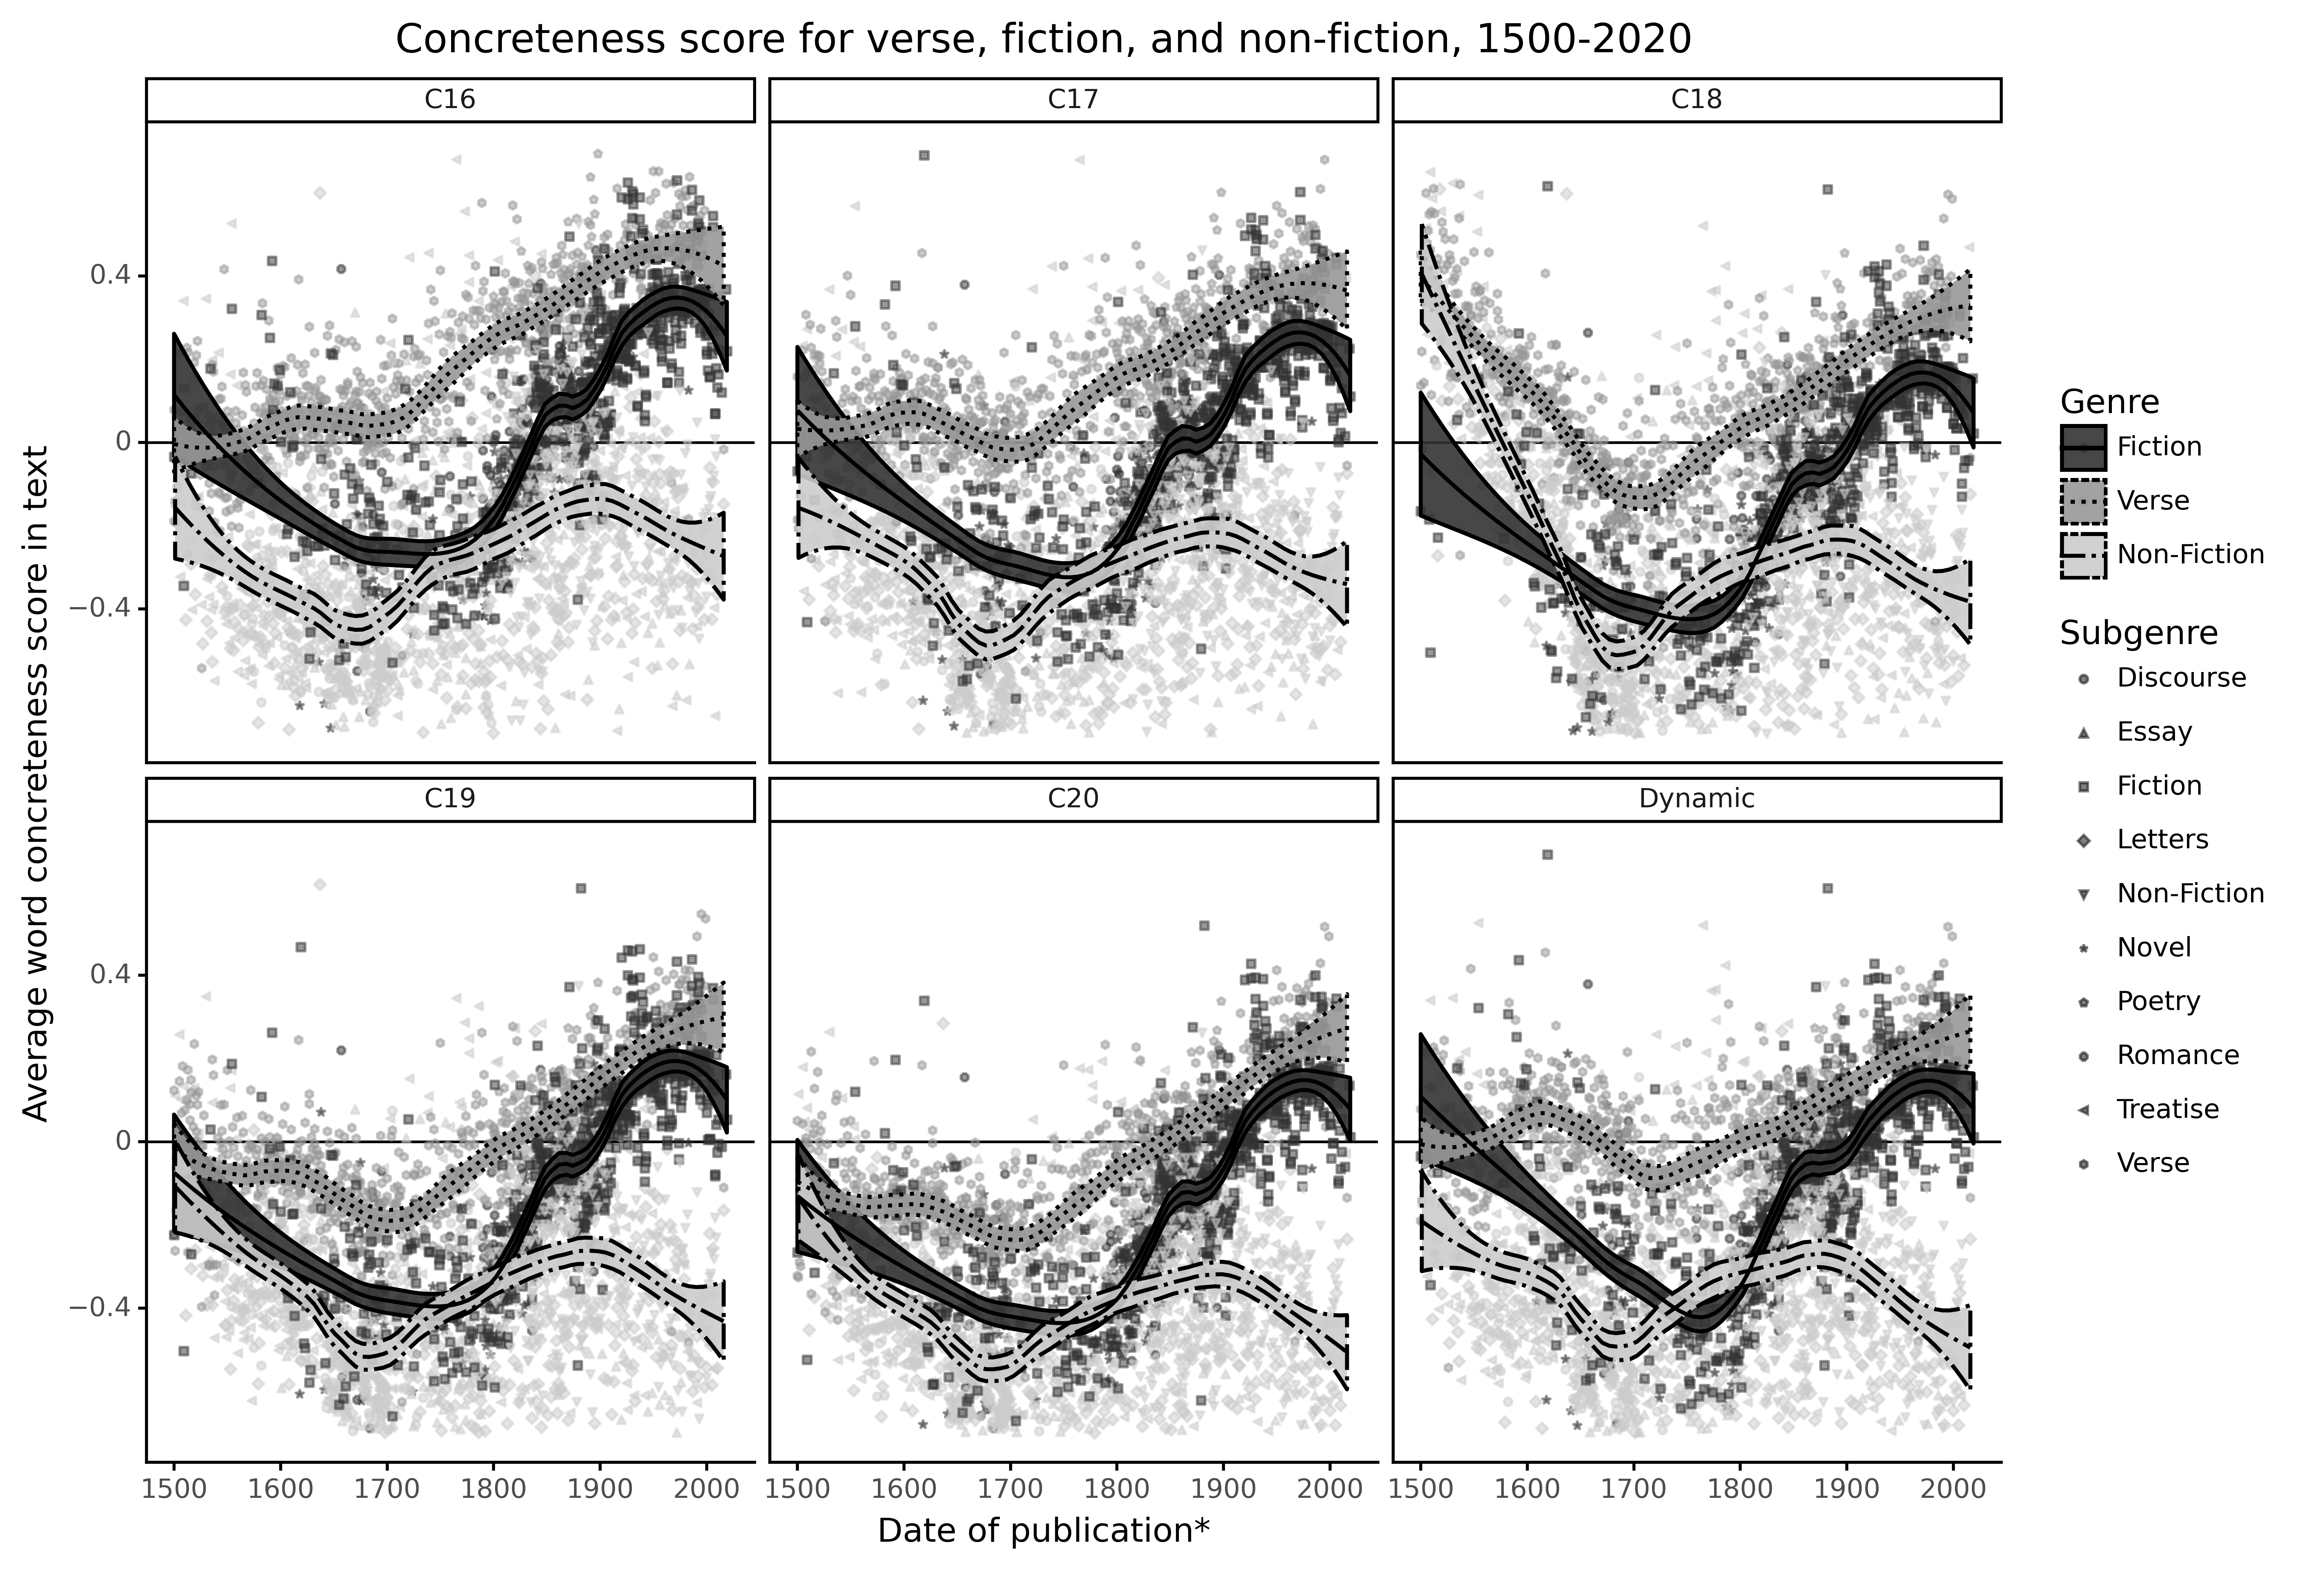

<ggplot: (8785705136613)>

In [41]:
p9.options.dpi=600
p9.options.figure_size=11,8
figdf2=figdf#[figdf.period!='median'].dropna()
fig=p9.ggplot(p9.aes(x='year',y='value',shape='genre2',linetype='metagenre'), data=figdf)
fig+=p9.geom_hline(yintercept=0)
# fig+=p9.geom_point(size=1,alpha=1)
fig+=p9.geom_point(p9.aes(color='metagenre'),size=1,alpha=0.5)

figdfq=figdf2.query(f'{y1}<=year<={y2}')

lvl=0.99
spn=0.4

fig+=p9.geom_ribbon(
    p9.aes(group='metagenre',fill='metagenre'),
#     p9.aes(x='year',y='value',group='metagenre'),
    # p9.aes(x='dec',y='value',group='period'),
#     inherit_aes=False,
    stat='smooth',
    method = "loess",
    se=True,
    alpha=.9,
    size=.75,
    color='Black',
#     fill='white',
#     color='DimGray',
    level=lvl,
#     linetype='solid',
    span=spn,
    data=figdfq
)

fig+=p9.geom_smooth(p9.aes(group='metagenre'),color='Black',method='loess',se=False,
    span=spn,size=.75,data=figdfq, level=lvl
)


fig+=p9.facet_wrap('period')

fig+=p9.labs(
    title=f'Concreteness score for verse, fiction, and non-fiction, {y1}-{y2}',
    x='Date of publication*',
    y='Average word concreteness score in text',
    shape='Subgenre',
    linetype='Genre',
    fill='Genre',
    group='Genre',
    color='Genre'
)
fig+=p9.ylim(-.7,.7)
fig+=p9.theme_classic()

# fig+=p9.scale_color_manual({
#     'Fiction':'#6e6e6e',
#     'Non-Fiction':'#8c8c8c',
#     'Verse':'#b3b3b3',
# })
# fig+=p9.scale_fill_manual({
#     'Fiction':'#6e6e6e',
#     'Non-Fiction':'#8c8c8c',
#     'Verse':'#b3b3b3',
# })

fig+=p9.scale_linetype_manual({
    'Fiction':'solid',
    'Non-Fiction':'dashdot',
    'Verse':'dotted',
})

fig+=p9.scale_fill_gray()
fig+=p9.scale_color_gray()
ofn='fig.biggerdata.scores.byperiod.v11.png'
fig.save(f'../../figures/{ofn}')
fig.save(f'/home/ryan/Markdown/Drafts/AbsRealism/figures/{ofn}')
fig